<a href="https://colab.research.google.com/github/kishoreVP/DOG-BREED-PREDICTOR/blob/main/DOG_BREEDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to end multiclass Dog breed classification

In [ ]:
#unziping the folder
# !unzip "/content/drive/MyDrive/data/dog-breed-identification.zip" -d"/content/drive/MyDrive/data"

* 1.problem
  indentifying the breed of the dog given a photo of it
* 2.data
  we have imported the data from kaggle
 * 3.evaluation
  the evaluation metrics: MULTI CLASS LOG LOSS
  The evaluation is a file which contains prediction
  probability for each dog  breed of each test image
* 4.features
  some info about the data
    * we are dealing images(unstructured) so its best to
     deep learning/transfer learning
    * there are 120 classes of different dog breeds
     (multi-class classification)
    * there is 10000+ images in train and test test (test
      set doesnt have labels)

## getting our workspace ready
importing tensorflow and tensorflow hub
making sure that we are using GPU


In [ ]:
# importing all required modules and lib
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## GETTING DATA READY

In [ ]:

# exploring the labels
labels_csv = pd.read_csv("/content/drive/MyDrive/data/labels.csv")
labels_csv.head()
# image ids are file names

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


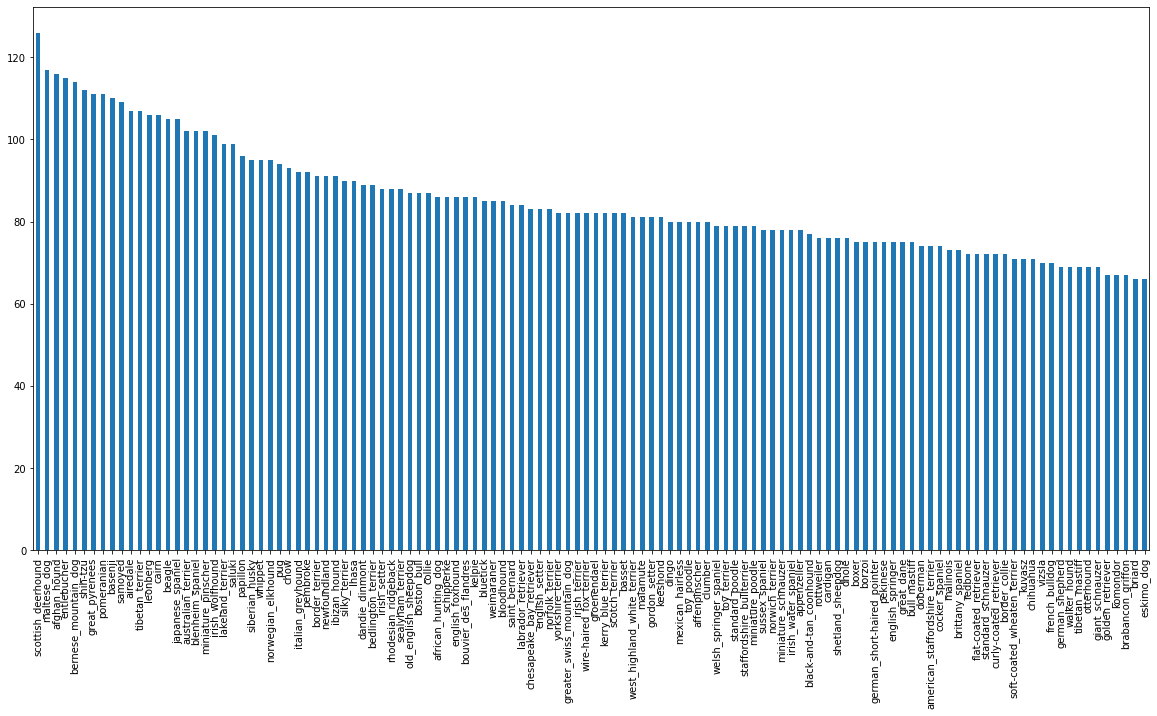

In [ ]:
labels_csv.breed.value_counts().plot.bar(figsize=(20
                                              ,10));

In [ ]:
# <<now no need to run this cell
# getting the file path of each image in train set
import os
images_loc = ["/content/drive/MyDrive/data/train/"+fname+".jpg" for fname in labels_csv["id"]]

# checking if the len are same and noting is missing
if len(os.listdir("/content/drive/MyDrive/data/train/")) == len(images_loc):
  print("you are good to go")
else:
  print("there is something wrong")

you are good to go


In [ ]:

# preparing labels
labels=labels_csv.breed.to_numpy()
# checking if both len are equal
len(labels),len(images_loc)

(10222, 10222)

In [ ]:
# labels
unique_breeds = np.unique(labels)
# turing every labels into bool
# labels[0]==unique_breeds==>using this
bool_labels =[label==unique_breeds for label in labels]
np.array(bool_labels)



array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# setting up X&y variables
X=images_loc
y=bool_labels

# first starting low with examples then increase as needed
# lets like with ~1000 samples

In [ ]:
# set the number of samples for experimenting
NUM_IMAGES =1000#@param {type:"slider",min:1000,max:10000,step:1000}

In [ ]:
# train and validation
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],
                                              y[:NUM_IMAGES],
                                              test_size=0.2,
                                              random_state=42)
len(X_train),len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

## PREPROCESSING

In [ ]:
# turing into tensors with  an function
IMAGE_SIZE=224
def image_processor(file_location,image_size=IMAGE_SIZE):
  '''
  takes in the filelocation and convert it into tensors and reshape it
  '''
  # reading the image
  image=tf.io.read_file(file_location)
  # decode jpeg into tensors with colour channels (RGB)
  image=tf.image.decode_jpeg(image,channels=3)
  # convert the range of colour channels from 0-255 to 0-1
  image=tf.image.convert_image_dtype(image,tf.float32)
  # resize the image into our desire values(224,224)
  image=tf.image.resize(image,size=[image_size,image_size])

  return image


turing our image into batches..since its more efficent to do this way.

we need to transform our data into a tensor tuples .format:(image,label)

and our label can be converted to tensor using `tf.constant()`

In [ ]:
# turing our image into batches..since its more efficent to do this way.
# we need to transform our data into a tensor tuples .format:(image,label)
def get_image_labels(file_location,labels):
  # processing image
  image=image_processor(file_location)
  return image,labels

In [ ]:
# an function that turns data into batches
BATCH_SIZE = 32 #ideal number of models
def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  '''
  convert data into batches
  '''
  if test_data:
    print("process test data")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X))# creating an tf dataset with an correct format
    data_batches=data.map(image_processor).batch(BATCH_SIZE)# creating data batches
    return data_batches
  elif valid_data:
    print("processing valid data")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))# creating an dataset with the correct format
    data_batches = data.map(get_image_labels).batch(BATCH_SIZE)# creating data batches
    return data_batches
  else:
    print("processing train data")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    # shuffing data before preprocessing
    data = data.shuffle(buffer_size=len(X))
    # preprocesing and shuffling
    data_batches = data.map(get_image_labels).batch(BATCH_SIZE)
    return data_batches


In [ ]:
train_batches= create_data_batches(X_train,y_train)
val_batches = create_data_batches(X_val,y_val,valid_data=True)
train_batches.element_spec

processing train data
processing valid data


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

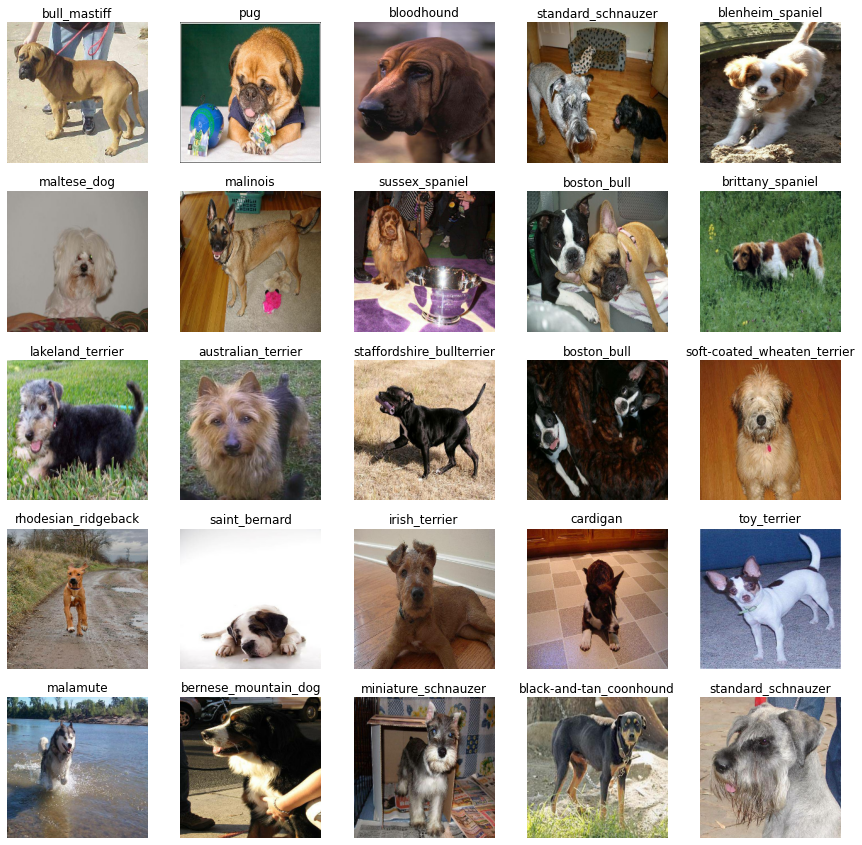

In [ ]:
# <<<dont need to run this:
# vishualizing our data
def show_25_img(images,labels):
   plt.figure(figsize=(15,15))
   for i in range(25):
     ax=plt.subplot(5,5,i+1)
     plt.imshow(images[i])
     plt.title(unique_breeds[labels[i].argmax()])
     plt.axis("off")
# we need to unbatch it
train_image,train_label=next(train_batches.as_numpy_iterator())
show_25_img(train_image,train_label)

# MODELING
* using tesnsorflow hub..
* by transfer learning
* got the url from tensorflow hub

In [ ]:
# defing the input and output varibles
INPUT_SHAPE = [None,IMAGE_SIZE,IMAGE_SIZE,3]
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:

# defing a function for model instanciating
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print(f"crearting an model with:{model_url}")

  # building an model
  model = tf.keras.Sequential([
                              hub.KerasLayer(MODEL_URL),
                              tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax")
                              ])
  # compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy']
                )
  # building a model
  model.build(INPUT_SHAPE)
  return model

## creating call backs

* tensor_board
* early stopping to prevent overfitting

In [ ]:

# load tesnorboard extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# tesnor_board
import datetime

def create_tensor_board():
  # creating dir with name of the time,for the log to save
  logdir=os.path.join("/content/drive/MyDrive/data/logs",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

## TRAINING A MODEL
* (subset of the dataset(1000 images to make sure everything is working)

In [ ]:
NUM_EPOCHS = 100#@param{type:"slider",min:10,max:100,step:10}

In [ ]:
def train_model():
  # creating an model
  model = create_model()
  tensorboard = create_tensor_board()
  # fiting the model with the call backs
  model.fit(x=train_batches,
            epochs=NUM_EPOCHS,
            validation_data=val_batches,
            callbacks=[tensorboard,early_stopping])

  return model

In [ ]:
# model1= train_model()

In [ ]:
# evaluating performance using tensorboard
%tensorboard --logdir /content/drive/MyDrive/data/logs

In [ ]:
# making some prediction
# predictions= model1.predict(val_batches,verbose=True)
# predictions.shape

In [ ]:
# creating an function to evaluate and vishualize prediction
# finds the predicted label
def get_pred_labels(prediction_proba):
  '''
  returns the label corresponding to the max proba value
  '''
  return unique_breeds[np.argmax(prediction_proba)]

# unbatches the data
def unbatchify(data):
  '''
  unbatches the data into lists of labels and and images
  '''
  images=[]
  true_labels=[]

  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    true_labels.append(unique_breeds[np.argmax(label)])

  return images,true_labels

# unbatching the data batches
val_images,val_labels=unbatchify(val_batches)

In [ ]:
# vishualizing prediction,true labels and images
def plot_preds(predictions_proba,labels,images,n=1):
  pred_proba,true_label,image =predictions_proba[n],labels[n],images[n]

  pred_label = get_pred_labels(pred_proba)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if true_label==pred_label:
    colour="green"
  else:
    colour="red"

  plt.title(f"pd:{pred_label} ,t_L:{true_label}, prb:{np.max(pred_proba)*100:2.0f}% ",color=colour)

In [ ]:
# top ten prediction of the label and vishualize it
def plot_pred_conf(pred_proba,true_labels,n=1):
  '''
  top ten prediction of the label and vishualize it
  '''

  pred_prob,label = pred_proba[n],true_labels[n]
  pred_label=get_pred_labels(pred_prob)

  # get the top ten prediction index
  top_10_index = pred_prob.argsort()[-10:][::-1]
  # get the top ten labels
  top_10_labels = unique_breeds[top_10_index]
  # get the top prediction values
  top_10_prdval = pred_prob[top_10_index]

  # setup a plot
  top_plot= plt.bar(np.arange(len(top_10_labels)),
                    top_10_prdval,
                    color="grey")
  plt.xticks(np.arange(len(top_10_labels)),
             labels=top_10_labels,
             rotation="vertical")
  # change color of true labels
  if np.isin(label,top_10_labels):
    top_plot[np.argmax(top_10_labels==label)].set_color("green")
  else:
    pass

In [ ]:
# plot_pred_conf(predictions,val_labels,n=1)

In [ ]:
# i_multiplier=0
# num_rows=3
# num_cols=2
# num_images=num_rows*num_cols
# plt.figure(figsize=(10*num_cols,5*num_rows))
# for i in range(num_images):
#    plt.subplot(num_rows,num_cols*2,2*i+1)
#    plot_preds(predictions,val_labels,val_images,n=i+i_multiplier)

#    plt.subplot(num_rows,2*num_cols,2*i+2)
#    plot_pred_conf(predictions,val_labels,(i+i_multiplier))
# plt.tight_layout(h_pad=1.0)
# plt.show

# # find how to use confusion matrix

# SAVING AND LOADING THE MODEL

In [ ]:
# saving an model

def save_model(model,suffix=None):
  modeldir=os.path.join("/content/drive/MyDrive/models",datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

  model_path = modeldir+"-"+suffix+".h5"
  # Saving
  model.save(model_path)
  return model_path
# SAVING OUR MODEL


In [ ]:
# loading an model
def load_model(model_directory):
  model=tf.keras.models.load_model(model_directory,
                                   custom_objects={"KerasLayer":hub.KerasLayer})
  return model


# TRAINING ON FULL DATA SET

In [ ]:
# turing whole data into batches
full_data=create_data_batches(X,y)

full_model=create_model()
# instanciating call backs
tensor_board=create_tensor_board()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

processing train data
crearting an model with:https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:

#  fitting the model
# full_model.fit(x=full_data,
#                 batch_size=BATCH_SIZE,
#                 epochs=100,
#                 callbacks=[tensor_board,full_model_early_stopping])


In [ ]:
# saving the model
# model_path=save_model(full_model,suffix="full_data-mobilv2-adam_real")

In [ ]:
# Load in the full model
loaded_full_model = load_model("/content/drive/MyDrive/models/20210923-12031632398597-full_data-mobilv2-adam_real.h5")

# Load in the full model
loaded_full_model = load_model(model_path)

# prediction on custom images


In [ ]:
# Get custom image filepaths
custom_path = "/content/drive/MyDrive/custom_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

process test data


In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_labels(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['labrador_retriever',
 'norfolk_terrier',
 'greater_swiss_mountain_dog',
 'chihuahua',
 'french_bulldog',
 'pomeranian',
 'german_shepherd',
 'boston_bull']

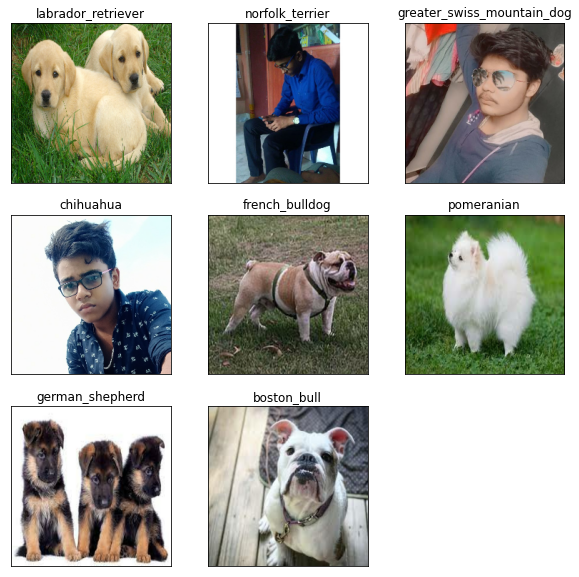

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(3,3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)